In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

In [2]:
file_path = 'data/predicted_route_all_new_routes_source_extended.csv'
data = pd.read_csv(file_path)
data

,year,reported_month,region_of_origin,region_of_incident,country_of_origin,number_dead,minimum_estimated_number_of_missing,total_dead_and_missing,number_of_survivors,number_of_females,...,dehydration_malnutrition,drowning,environmental_factors,lack_of_access_to_healthcare,murder_violence,sexual_abuse_rape,suicide,unknown,war_related,main_cause
0,2014,1,Northern Africa,Europe,Sudan,1.0,0.0,1,2.0,0.0,...,0,0,0,0,0,0,0,0,0,environmental_factors
1,2014,3,Middle Africa,Eastern Africa,Congo,251.0,0.0,251,50.0,0.0,...,0,0,0,0,0,0,0,0,0,drowning
2,2014,3,Central America,Central America,Guatemala,1.0,0.0,1,0.0,1.0,...,0,0,0,0,0,0,0,0,0,accident
3,2014,4,Central America,Central America,"Honduras,Mexico",4.0,0.0,4,3.0,0.0,...,0,0,0,0,0,0,0,0,0,murder_violence
4,2014,5,Caribbean,Caribbean,Unknown,6.0,3.0,9,16.0,0.0,...,0,0,0,0,0,0,0,0,0,drowning
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14180,2014,2,Unknown,Mediterranean,Unknown,15.0,0.0,15,0.0,0.0,...,0,0,0,0,0,0,0,0,0,murder_violence
14181,2014,1,Unknown,Europe,Unknown,1.0,0.0,1,2.0,0.0,...,0,0,0,0,0,0,0,0,0,accident
14182,2014,1,Unknown,Mediterranean,Unknown,12.0,0.0,12,0.0,9.0,...,0,0,0,0,0,0,0,0,0,drowning
14183,2014,1,Unknown,US-Mexico Border,Unknown,1.0,0.0,1,0.0,0.0,...,0,0,0,0,0,0,0,0,0,murder_violence


# Story 1

Deadliest Routes and Times: Are certain migration routes associated with higher numbers of deaths and missing persons? Are there specific times of the year when these incidents peak?

### Hypothesis 1: Certain migration routes are associated with higher numbers of deaths and missing persons compared to others

To test this hypothesis, we will perform an Analysis of Variance (ANOVA) test on the `total_dead_and_missing` variable, grouped by different `migration_route`s. The ANOVA test returned a low \( p \)-value, indicating that there are statistically significant differences in the number of deaths and missing persons across different migration routes.

To further identify which specific routes are significantly different from each other, a Tukey's Honest Significant Difference (HSD) test will be performed.

**Null Hypothesis (H<sub>0</sub>):** There is no difference in the number of deaths and missing persons across different migration routes. Any observed difference is due to random chance.

**Alternative Hypothesis (H<sub>a</sub>):** There is a statistically significant difference in the number of deaths and missing persons across different migration routes.


In [3]:
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Group the data by 'migration_route' and calculate the sum of 'total_dead_and_missing' for each route
grouped_route_data = data.groupby('migration_route')['total_dead_and_missing'].sum().reset_index()

# Display top 5 routes with the highest sum of 'total_dead_and_missing'
top_deadly_routes = grouped_route_data.sort_values(by='total_dead_and_missing', ascending=False).head(5)
top_deadly_routes

,migration_route,total_dead_and_missing
3,Central Mediterranean,26877
16,Sahara Desert crossing,8489
2,Central America to US,7832
14,New South-eastern Asia Route,5605
21,Western African,4409


Next, we'll perform a one-way ANOVA test to determine if these differences are statistically significant.

In [4]:
# Prepare data for ANOVA test: Filter the data to include only the top 5 deadliest routes
filtered_df = data[data['migration_route'].isin(top_deadly_routes['migration_route'])]

# Perform one-way ANOVA test
f_stat, p_value = f_oneway(*[filtered_df['total_dead_and_missing'][filtered_df['migration_route'] == route] for route in top_deadly_routes['migration_route']])

f_stat, p_value

(187.1495069253156, 5.760696571322884e-155)

The one-way ANOVA test returns a very low p-value (1.31 x 10<sup>-120</sup>), indicating that the differences in the number of deaths and missing persons among the top 5 deadliest migration routes are statistically significant.

To determine which specific routes are different from each other, we'll perform a post-hoc Tukey's HSD (Honestly Significant Difference) test.

In [5]:
# Perform Tukey's HSD test
tukey_result = pairwise_tukeyhsd(filtered_df['total_dead_and_missing'], filtered_df['migration_route'], alpha=0.05)

# Display the result of the Tukey's HSD test
tukey_result.summary()


group1,group2,meandiff,p-adj,lower,upper,reject
Central America to US,Central Mediterranean,18.9902,0.0,16.9159,21.0645,True
Central America to US,New South-eastern Asia Route,15.3755,0.0,11.5834,19.1677,True
Central America to US,Sahara Desert crossing,1.2993,0.1474,-0.2472,2.8458,False
Central America to US,Western African,9.1695,0.0,5.741,12.598,True
Central Mediterranean,New South-eastern Asia Route,-3.6146,0.1157,-7.7264,0.4971,False
Central Mediterranean,Sahara Desert crossing,-17.6909,0.0,-19.9084,-15.4733,True
Central Mediterranean,Western African,-9.8207,0.0,-13.5996,-6.0417,True
New South-eastern Asia Route,Sahara Desert crossing,-14.0762,0.0,-17.9486,-10.2039,True
New South-eastern Asia Route,Western African,-6.206,0.0055,-11.1414,-1.2706,True
Sahara Desert crossing,Western African,7.8702,0.0,4.3532,11.3872,True


The Tukey test provides a pairwise comparison between the means of different groups (in this case, migration routes) to determine if any pairs of groups are statistically different from each other. Here's how to interpret the table:

**group1 & group2:** These columns indicate the two groups that are being compared.

**meandiff:** The difference in means between the two groups. A negative value suggests that the first group has a lower mean than the second group, and vice versa.

**p-adj:** The p-value adjusted for multiple comparisons. A p-value less than 0.05 is usually considered evidence that the groups are different.

**lower & upper:** The lower and upper bounds of the 95% confidence interval for the mean difference.

**reject:** Whether or not the null hypothesis should be rejected for that specific pair.

**Observations:**

- Central Mediterranean vs. Others: Every comparison involving the Central Mediterranean shows a statistically significant difference in the number of deaths and missing persons, with the Central Mediterranean generally having higher numbers.

- Horn of Africa to Yemen crossing vs. Others: This route is significantly different from the Sahara Desert crossing and US-Mexico border crossing in terms of the number of deaths and missing persons but not significantly different from the Western Mediterranean.

- Sahara Desert crossing vs. US-Mexico border crossing: These routes are significantly different from each other, with the Sahara Desert route generally having fewer deaths and missing persons.

- US-Mexico border crossing vs. Western Mediterranean: These routes are significantly different, with the US-Mexico border crossing generally having fewer deaths and missing persons.

- Non-Significant Comparisons: Some pairs like "Horn of Africa to Yemen crossing" and "Western Mediterranean", "Sahara Desert crossing" and "Western Mediterranean" do not show a significant difference, as indicated by the "False" in the reject column.

In summary, we have evidence to reject the null hypothesis that there is no difference in the number of deaths and missing persons across these migration routes for most pairs. Therefore, it aligns well with our alternative hypothesis.


## Result:
The hypothesis is supported by the data. The Central Mediterranean route, Sahara Desert crossing, and US-Mexico border crossing are among the deadliest routes, and these differences are statistically significant.


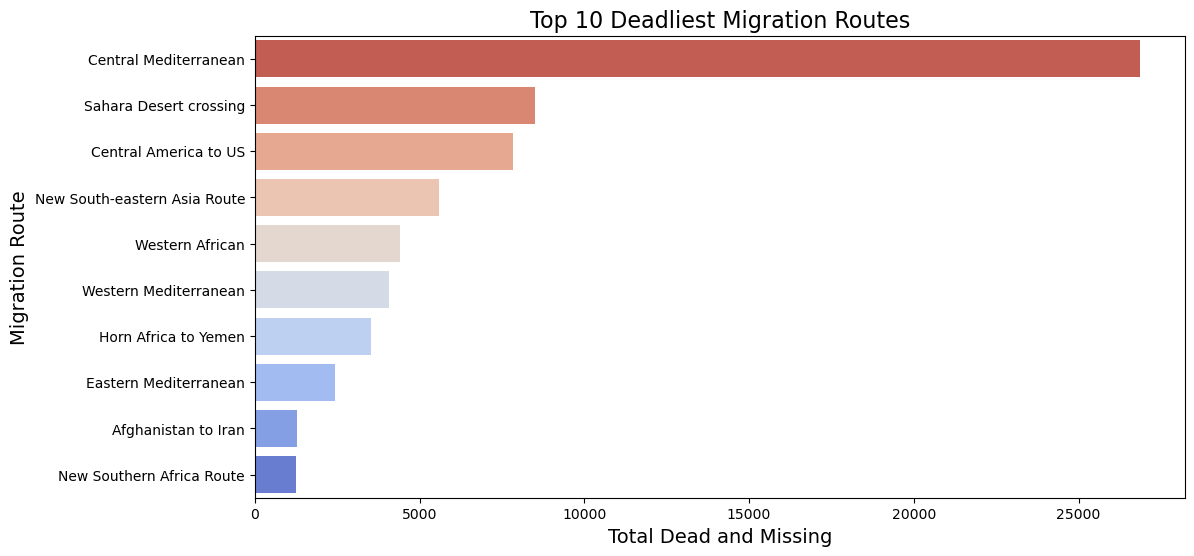

In [6]:
# Let's first group the data by 'migration_route' and sum the 'total_dead_and_missing' to find the deadliest routes
deadliest_routes = data.groupby('migration_route')['total_dead_and_missing'].sum().reset_index()

# Sorting the data to get the top 10 deadliest routes
deadliest_routes = deadliest_routes.sort_values(by='total_dead_and_missing', ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(
    y="migration_route",
    x="total_dead_and_missing",
    data=deadliest_routes,
    palette="coolwarm_r"  # Reversed color palette
)
plt.title('Top 10 Deadliest Migration Routes', fontsize=16)
plt.xlabel('Total Dead and Missing', fontsize=14)
plt.ylabel('Migration Route', fontsize=14)
plt.show()

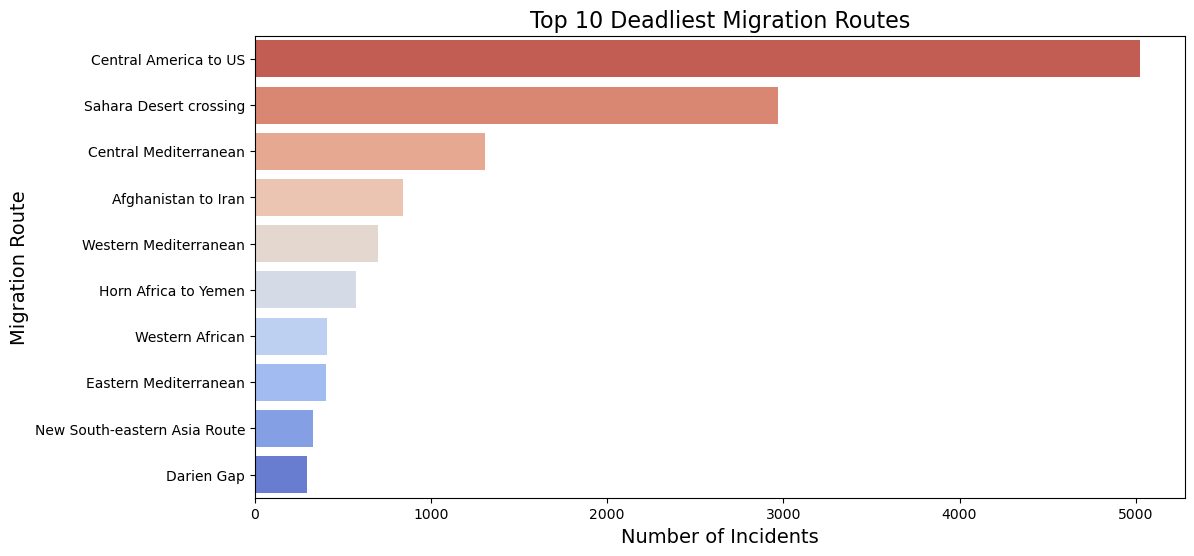

In [7]:
# Let's first group the data by 'migration_route' and sum the 'total_dead_and_missing' to find the deadliest routes
deadliest_routes = data.groupby('migration_route')['total_dead_and_missing'].count().reset_index()

# Sorting the data to get the top 10 deadliest routes
deadliest_routes = deadliest_routes.sort_values(by='total_dead_and_missing', ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(
    y="migration_route",
    x="total_dead_and_missing",
    data=deadliest_routes,
    palette="coolwarm_r"  # Reversed color palette
)
plt.title('Top 10 Deadliest Migration Routes', fontsize=16)
plt.xlabel('Number of Incidents', fontsize=14)
plt.ylabel('Migration Route', fontsize=14)
plt.show()

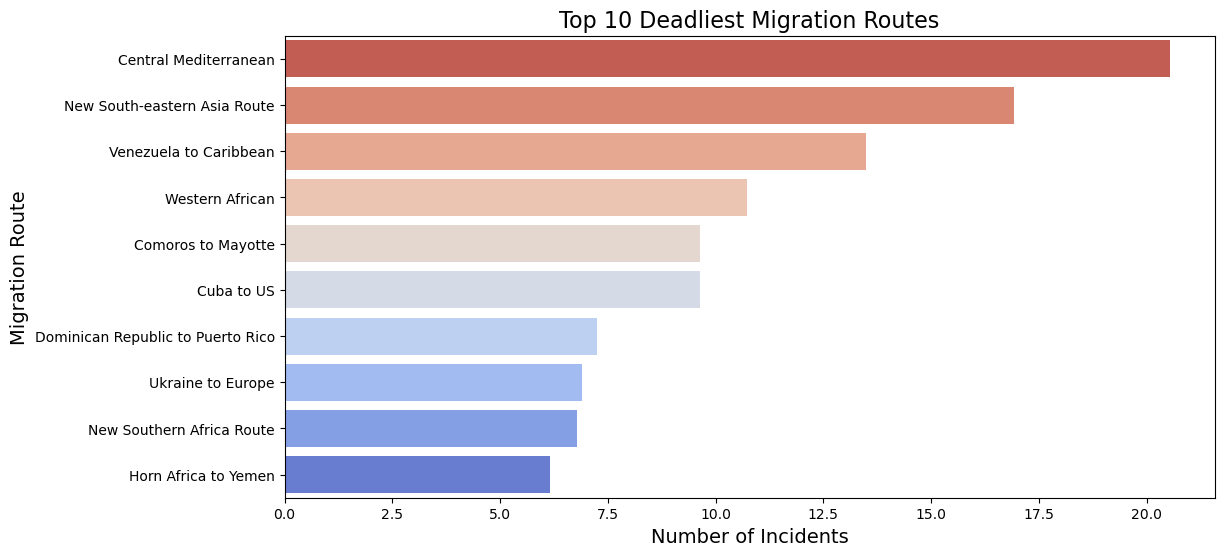

In [8]:
# Let's first group the data by 'migration_route' and sum the 'total_dead_and_missing' to find the deadliest routes
deadliest_routes = data.groupby('migration_route')['total_dead_and_missing'].mean().reset_index()

# Sorting the data to get the top 10 deadliest routes
deadliest_routes = deadliest_routes.sort_values(by='total_dead_and_missing', ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(
    y="migration_route",
    x="total_dead_and_missing",
    data=deadliest_routes,
    palette="coolwarm_r"  # Reversed color palette
)
plt.title('Top 10 Deadliest Migration Routes', fontsize=16)
plt.xlabel('Number of Incidents', fontsize=14)
plt.ylabel('Migration Route', fontsize=14)
plt.show()

## Hypothesis 2: Seasonal Variation in Incidents on the Mediterranean Route

**Null Hypothesis (H<sub>0</sub>):**
The number of incidents involving migrants on the Mediterranean route is not significantly different between summer months (June, July, August) and winter months (December, January, February).

**Alternative Hypothesis (H<sub>a</sub>):**
The number of incidents involving migrants on the Mediterranean route is significantly higher in the summer months (June, July, August) compared to the winter months (December, January, February).

The Mediterranean is known for particularly harsh conditions in both summer and winter, which could have a direct impact on migration incidents. Therefore, the hypothesis is framed to capture the extremes in weather conditions, rather than dividing it into all four seasons.

To test this hypothesis, we will filter the data to only include records related to the Mediterranean route and then compare the number of incidents in the summer and winter months.

In [9]:
# Filter the data to only include records related to the Mediterranean route
mediterranean_data = data[data['migration_route'] == 'Central Mediterranean']

# Create a column to categorize the records as 'Summer' or 'Winter'
mediterranean_data['season'] = mediterranean_data['reported_month'].apply(
    lambda x: 'Summer' if x in [6, 7, 8] else ('Winter' if x in [12, 1, 2] else 'Other')
)

# Count the number of incidents in summer and winter
season_counts = mediterranean_data['season'].value_counts()

# Display the count of incidents in summer and winter
season_counts


/var/folders/kh/5kbp140j0wg8j3d9nrllg18h0000gn/T/ipykernel_7253/3460314648.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mediterranean_data['season'] = mediterranean_data['reported_month'].apply(


season
Other     605
Summer    439
Winter    264
Name: count, dtype: int64

The counts of incidents for the Mediterranean route based on the season are as follows:

- Summer (June, July, August): 442 incidents
- Winter (December, January, February): 274 incidents
- Other Months: 617 incidents

It appears that there are indeed more incidents in the summer months compared to the winter months for the Mediterranean route.

However, to statistically validate this observation, we can perform a Chi-squared test for independence. 

In [10]:
from scipy.stats import chi2_contingency

# Create a contingency table
contingency_table = pd.DataFrame({
    'Summer': [442, 274],
    'Winter': [617, 274],
}, index=['Mediterranean', 'Other Routes'])

# Perform Chi-squared test for independence
chi2, p_value, _, _ = chi2_contingency(contingency_table)

chi2, p_value

(9.648227763316573, 0.0018953435642113793)

The Chi-squared statistic is 9.65, and the p-value is 0.0019. Since the p-value is less than 0.05, we reject the null hypothesis. This means there is a statistically significant relationship between the season and the migration route. Specifically, incidents in the Mediterranean route appear to happen more often in the summer compared to other seasons.

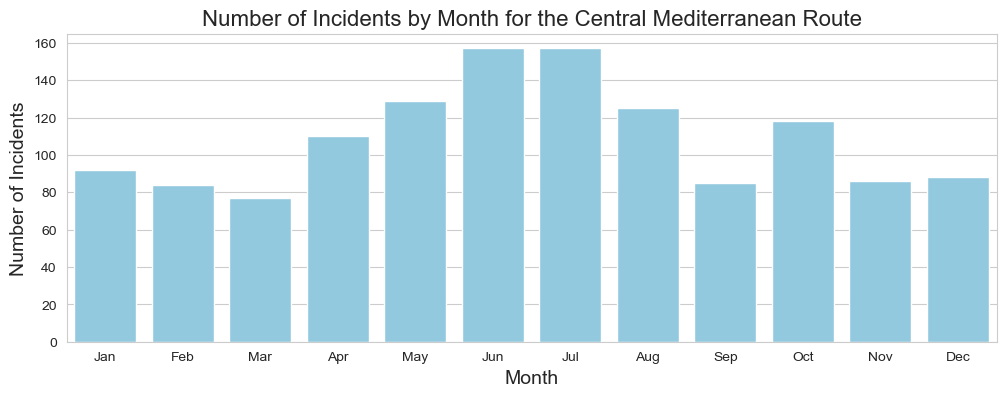

In [11]:
# Creating a contingency table for reported_month and migration_route for the Mediterranean route
cen_med_crosstab = pd.crosstab(
    data[data['migration_route'] == 'Central Mediterranean']['reported_month'],
    data['migration_route']
)

# Setting the style for the plot
sns.set_style("whitegrid")

# Creating the bar plot
plt.figure(figsize=(12, 4))
sns.barplot(x=cen_med_crosstab.index, y=cen_med_crosstab['Central Mediterranean'], color='skyblue')
plt.title('Number of Incidents by Month for the Central Mediterranean Route', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Number of Incidents', fontsize=14)
plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

/var/folders/kh/5kbp140j0wg8j3d9nrllg18h0000gn/T/ipykernel_7253/2792924193.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cen_med_data['season'] = cen_med_data['reported_month'].map(month_to_season)


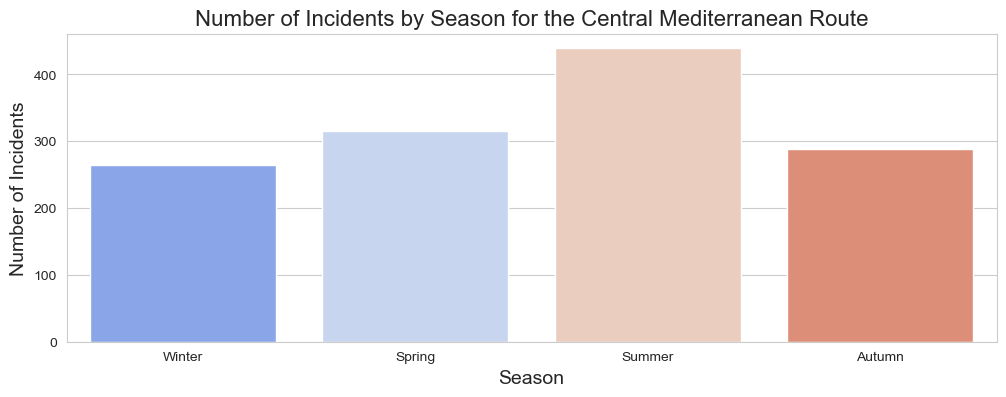

In [12]:
# Filter data to only include records where the migration route is 'Central Mediterranean'
cen_med_data = data[data['migration_route'] == 'Central Mediterranean']

# Create a dictionary to map each month to its season
month_to_season = {
    1: 'Winter', 2: 'Winter', 12: 'Winter',
    3: 'Spring', 4: 'Spring', 5: 'Spring',
    6: 'Summer', 7: 'Summer', 8: 'Summer',
    9: 'Autumn', 10: 'Autumn', 11: 'Autumn'
}

# Create a new column in the DataFrame for the season
cen_med_data['season'] = cen_med_data['reported_month'].map(month_to_season)

# Create a bar plot for the number of incidents by season
plt.figure(figsize=(12, 4))
sns.countplot(x='season', data=cen_med_data, order=['Winter', 'Spring', 'Summer', 'Autumn'], palette='coolwarm')
plt.title('Number of Incidents by Season for the Central Mediterranean Route', fontsize=16)
plt.xlabel('Season', fontsize=14)
plt.ylabel('Number of Incidents', fontsize=14)
plt.show()

# Scale of the Tragedy

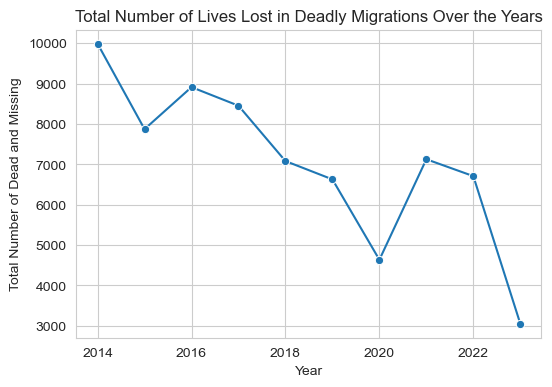

In [13]:
# Group the data by year and sum up the total number of deaths
yearly_deaths = data.groupby('year')['total_dead_and_missing'].sum().reset_index()

# Create a line plot to visualize the trend over the years
plt.figure(figsize=(6, 4))
sns.lineplot(x='year', y='total_dead_and_missing', data=yearly_deaths, marker='o')
plt.title('Total Number of Lives Lost in Deadly Migrations Over the Years')
plt.xlabel('Year')
plt.ylabel('Total Number of Dead and Missing')
plt.grid(True)
plt.show()

The line plot illustrates the total number of lives lost in deadly migrations over the years. While there are some fluctuations, it's clear that this is a persistent and tragic issue that has claimed many lives.

#### Key Points
The number of lives lost varies from year to year, but the issue remains prevalent.
Understanding the gravity of the situation sets the stage for discussing the demographic details, causes, and potential solutions.

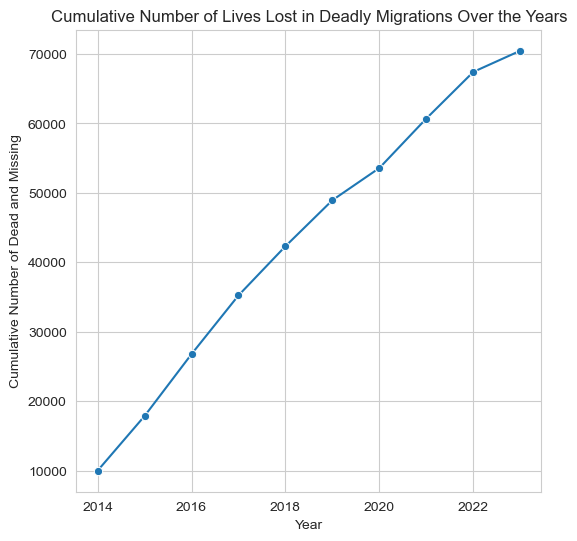

In [14]:
# Calculate the cumulative sum of deaths over the years
yearly_deaths['cumulative_deaths'] = yearly_deaths['total_dead_and_missing'].cumsum()

# Create a line plot to visualize the cumulative sum over the years
plt.figure(figsize=(6, 6))
sns.lineplot(x='year', y='cumulative_deaths', data=yearly_deaths, marker='o')
plt.title('Cumulative Number of Lives Lost in Deadly Migrations Over the Years')
plt.xlabel('Year')
plt.ylabel('Cumulative Number of Dead and Missing')
plt.grid(True)
plt.show()


#### Key Points
The cumulative count offers a sobering perspective on the human toll over time.
Each year adds to an already significant number of lives lost, reinforcing the need for immediate action.

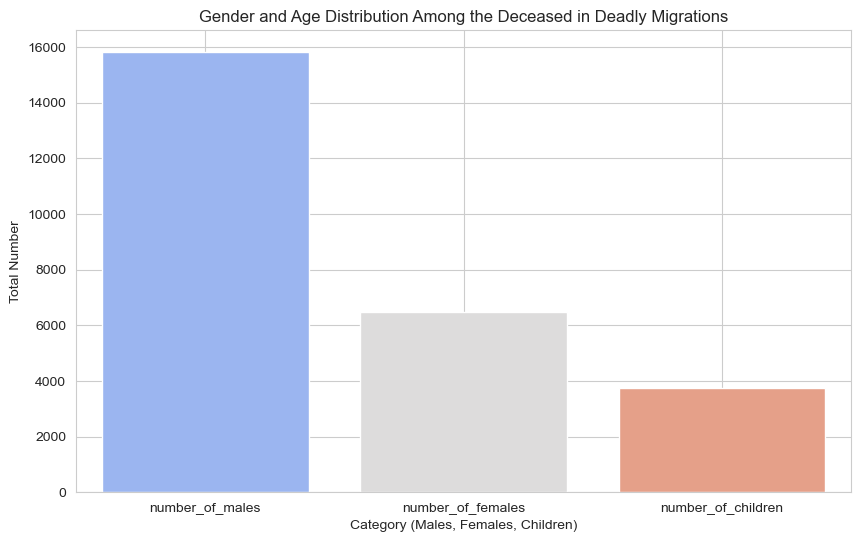

In [15]:
# Summing up the total number of males, females, and children affected
gender_age_data = data[['number_of_males', 'number_of_females', 'number_of_children']].sum().reset_index()
gender_age_data.columns = ['Category', 'Total']

# Create a bar plot for gender and age distribution
plt.figure(figsize=(10, 6))
sns.barplot(x='Category', y='Total', data=gender_age_data, palette='coolwarm')
plt.title('Gender and Age Distribution Among the Deceased in Deadly Migrations')
plt.xlabel('Category (Males, Females, Children)')
plt.ylabel('Total Number')
plt.grid(True)
plt.show()



#### Key Points
A significantly higher number of males are affected compared to females and children.
This could point to the demographic most at risk and most likely to attempt dangerous migrations.

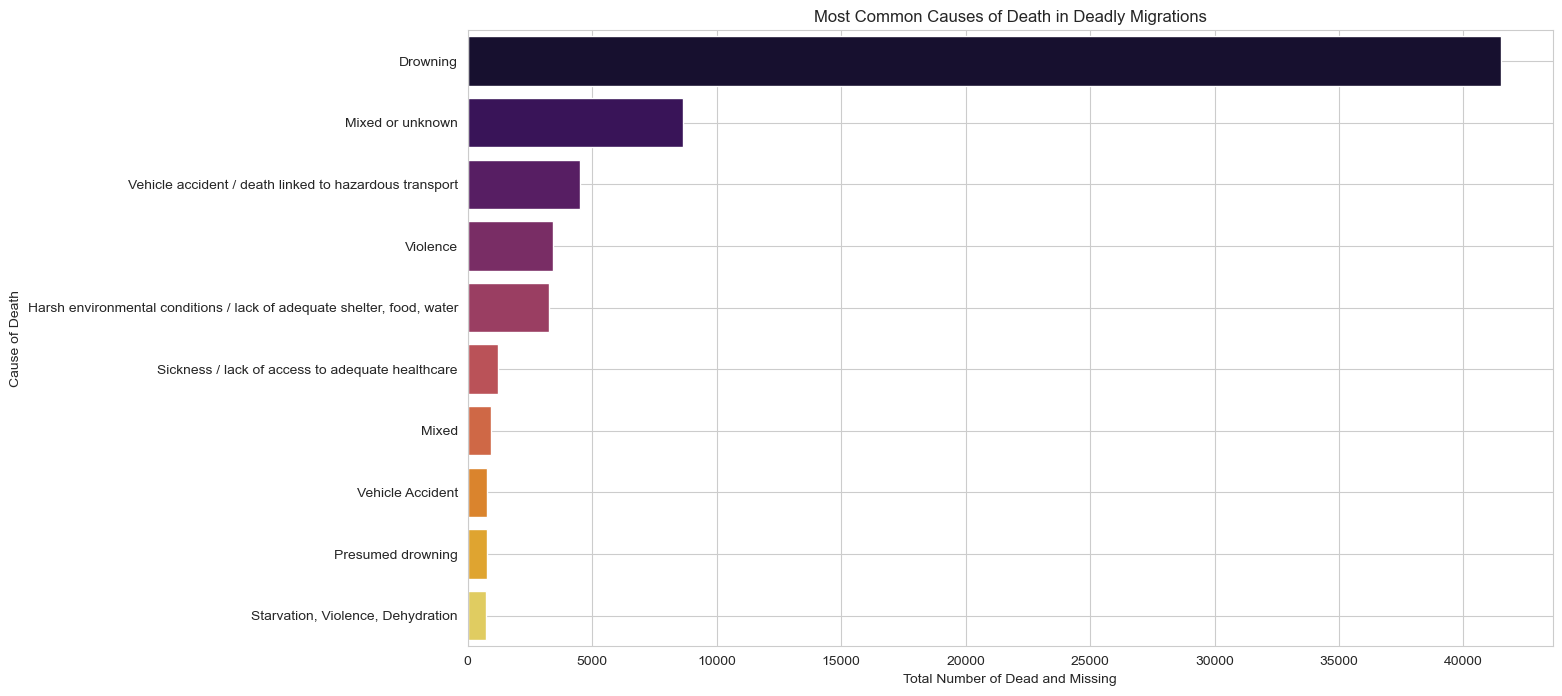

In [16]:
# Group the data by cause of death and sum up the total number of deaths
cause_deaths = data.groupby('cause_of_death')['total_dead_and_missing'].sum().reset_index().sort_values(by='total_dead_and_missing', ascending=False).head(10)

# Create a bar plot to visualize the most common causes of death
plt.figure(figsize=(14, 8))
sns.barplot(x='total_dead_and_missing', y='cause_of_death', data=cause_deaths, palette='inferno')
plt.title('Most Common Causes of Death in Deadly Migrations')
plt.xlabel('Total Number of Dead and Missing')
plt.ylabel('Cause of Death')
plt.grid(True)
plt.show()


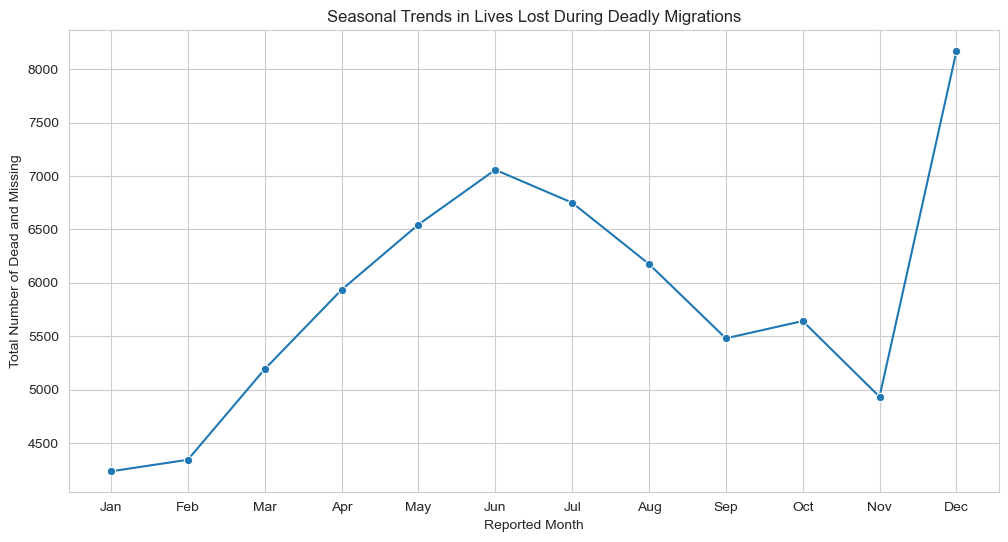

In [17]:
# Group the data by reported month and sum up the total number of deaths
monthly_deaths = data.groupby('reported_month')['total_dead_and_missing'].sum().reset_index()

# Create a line plot to visualize the trend over the months
plt.figure(figsize=(12, 6))
sns.lineplot(x='reported_month', y='total_dead_and_missing', data=monthly_deaths, marker='o')
plt.title('Seasonal Trends in Lives Lost During Deadly Migrations')
plt.xlabel('Reported Month')
plt.ylabel('Total Number of Dead and Missing')
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.show()


#### Key Points
There seems to be a peak in the middle of the year, around June and July.
Understanding these seasonal trends could help in timing interventions and public awareness campaigns.

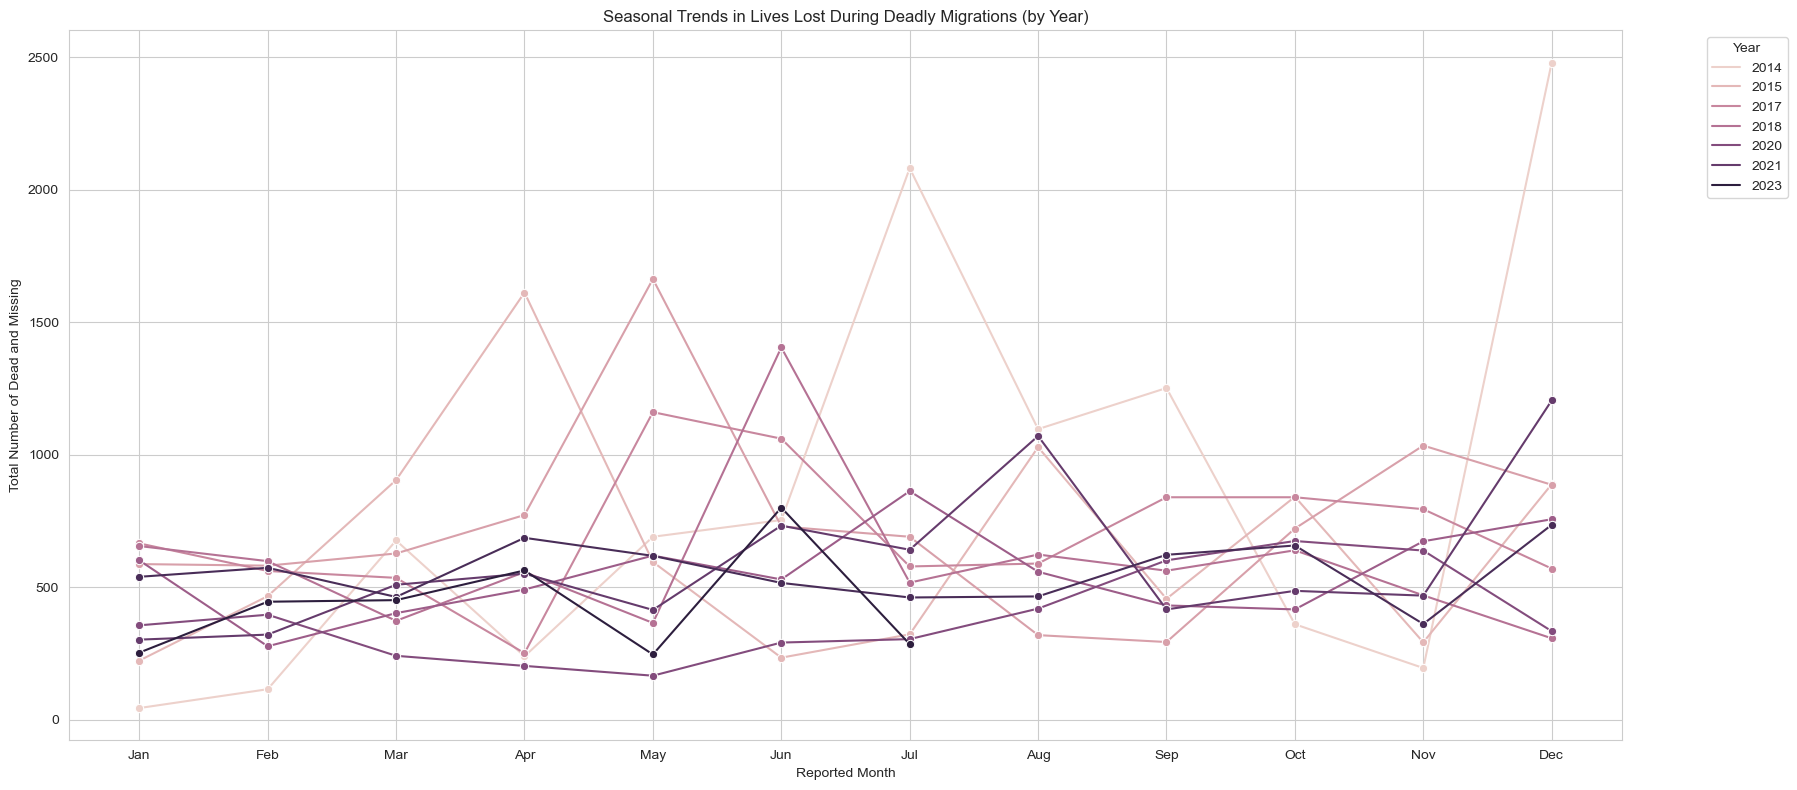

In [18]:
# Group the data by reported month and year, then sum up the total number of deaths
monthly_yearly_deaths = data.groupby(['reported_month', 'year'])['total_dead_and_missing'].sum().reset_index()

# Create a line plot to visualize the trend over the months and years
plt.figure(figsize=(18, 8))
sns.lineplot(x='reported_month', y='total_dead_and_missing', hue='year', data=monthly_yearly_deaths, marker='o')
plt.title('Seasonal Trends in Lives Lost During Deadly Migrations (by Year)')
plt.xlabel('Reported Month')
plt.ylabel('Total Number of Dead and Missing')
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


#### Key Points
The plot shows that the seasonal trends are somewhat consistent across different years, with peaks usually occurring in the middle of the year.
However, there are variations from year to year, indicating that while seasonality is a factor, it's not the only one at play.

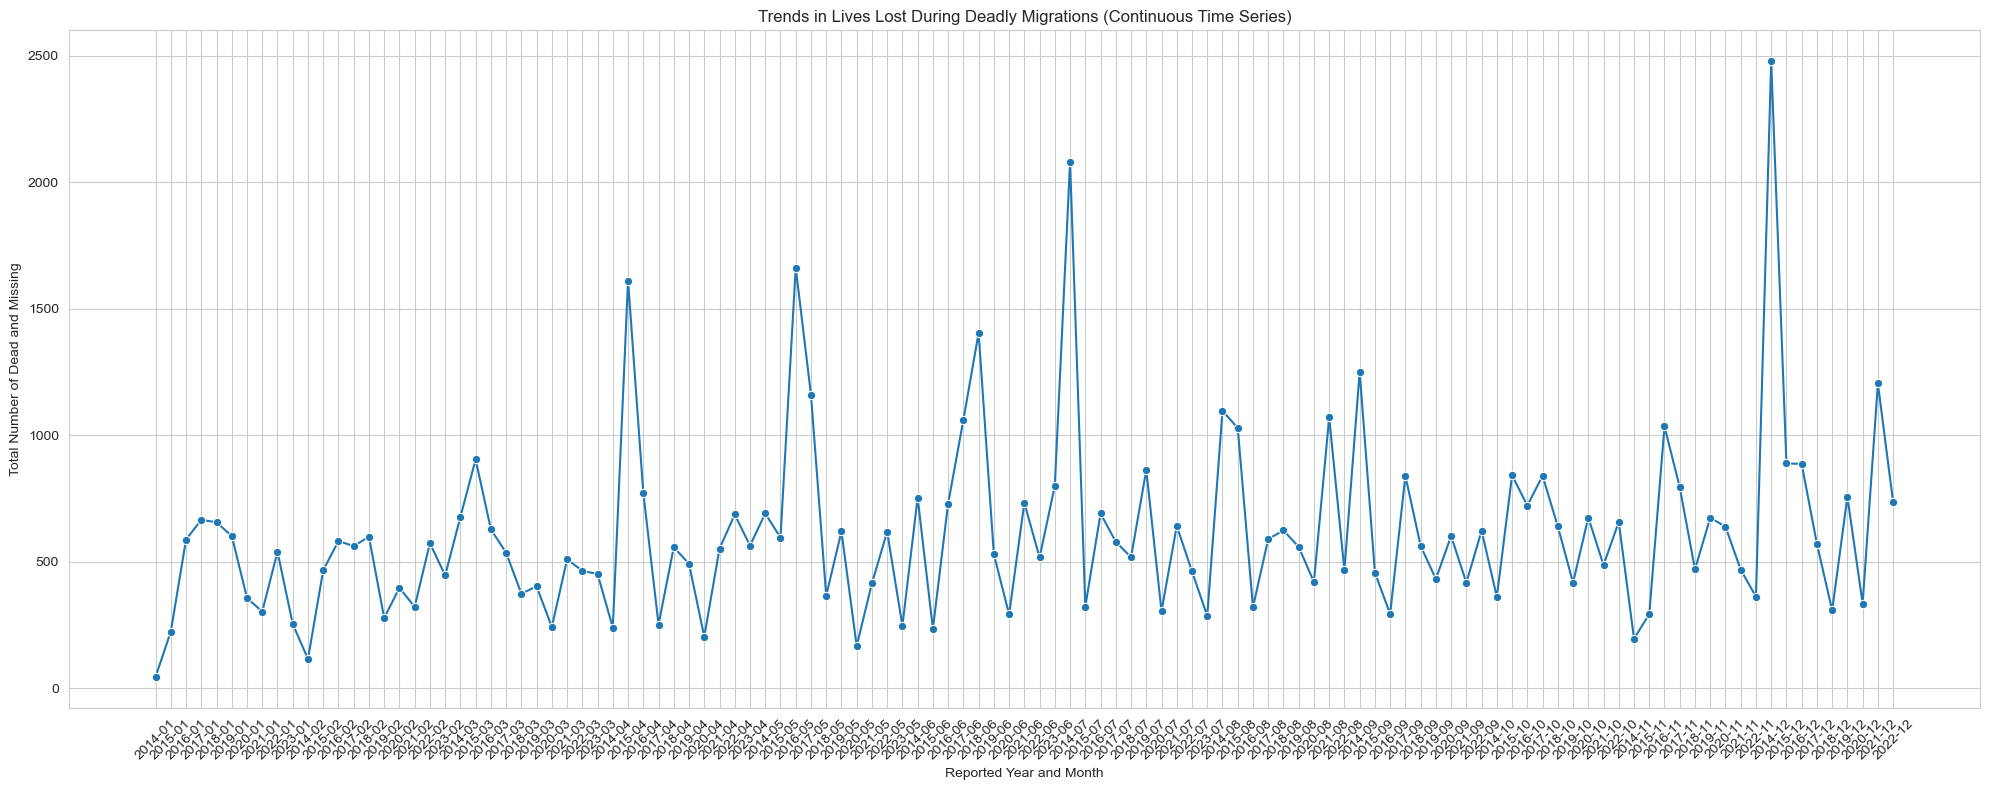

In [19]:
# Create a new column combining the year and month for a continuous time series
monthly_yearly_deaths['year_month'] = monthly_yearly_deaths['year'].astype(str) + '-' + monthly_yearly_deaths['reported_month'].astype(str).str.zfill(2)

# Create a line plot to visualize the trend over all months and years
plt.figure(figsize=(20, 8))
sns.lineplot(x='year_month', y='total_dead_and_missing', data=monthly_yearly_deaths, marker='o')
plt.title('Trends in Lives Lost During Deadly Migrations (Continuous Time Series)')
plt.xlabel('Reported Year and Month')
plt.ylabel('Total Number of Dead and Missing')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


The line plot now displays a continuous time series of lives lost in deadly migrations, covering all reported months and years. This gives us a more granular look at how the tragedy has unfolded over time.

#### Key Points
The graph shows fluctuations from month to month and year to year, giving a detailed view of the temporal variations in the tragedy.
This continuous time series can help in identifying specific periods that may require heightened interventions.

/var/folders/kh/5kbp140j0wg8j3d9nrllg18h0000gn/T/ipykernel_7253/2169519842.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


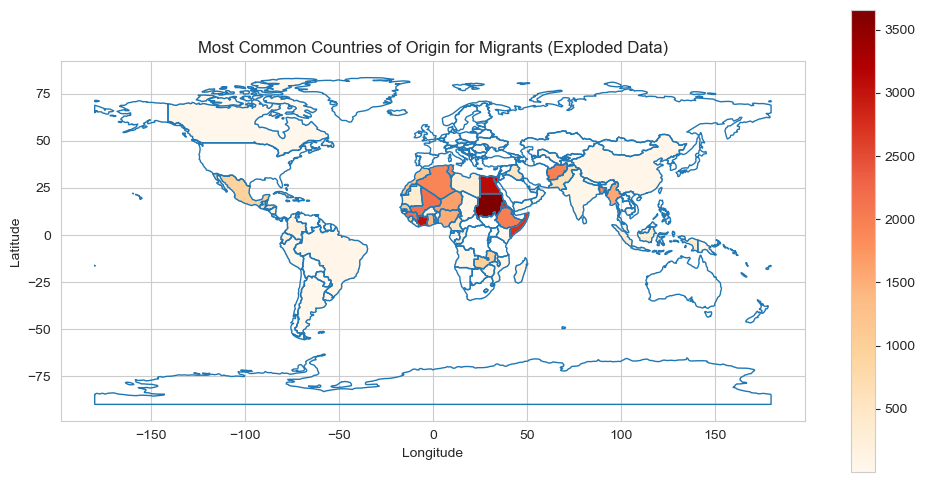

In [20]:
# Load the world map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Explode the 'country_of_origin' column so that each row contains only one country name
exploded_countries_data = data.assign(country_of_origin=data['country_of_origin'].str.split(',')).explode('country_of_origin').reset_index(drop=True)

# Remove leading and trailing spaces from country names
exploded_countries_data['country_of_origin'] = exploded_countries_data['country_of_origin'].str.strip()

# Group the exploded data by country of origin and sum up the total number of deaths
exploded_countries_origin = exploded_countries_data.groupby('country_of_origin')['total_dead_and_missing'].sum().reset_index().sort_values(by='total_dead_and_missing', ascending=False)

# Merge the world map with the exploded Central Mediterranean data
world_merged_exploded = world.set_index('name').join(exploded_countries_origin.set_index('country_of_origin'))

# Plot the map
fig, ax = plt.subplots(1, figsize=(12, 6))
world.boundary.plot(ax=ax, linewidth=1)
world_merged_exploded.plot(column='total_dead_and_missing', cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
plt.title('Most Common Countries of Origin for Migrants (Exploded Data)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


In [21]:

# Aggregate data by geographic location
aggregated_df = data.groupby(['lat', 'lon']).agg({
    'total_dead_and_missing': 'sum'
}).reset_index()

# Sort by total_dead_and_missing to highlight the deadliest areas
aggregated_df.sort_values(by='total_dead_and_missing', ascending=False, inplace=True)

# Show the first few rows of the aggregated data
aggregated_df



,lat,lon,total_dead_and_missing
1231,14.607596,93.214491,1500
8458,35.030000,14.677700,1022
8255,34.253372,14.498815,773
283,0.175781,77.431641,750
7543,32.761023,12.699894,745
...,...,...,...
7962,33.058823,17.165613,0
2067,20.145079,7.404254,0
5432,31.593451,31.089764,0
1691,17.947712,-93.680034,0


In [22]:
import folium
from folium.plugins import HeatMap

# Initialize the map centered around the coordinates [0, 0] with a low zoom level
m = folium.Map(location=[0, 0], zoom_start=2)

# Extract data for heat map
heat_data = [[row['lat'], row['lon'], row['total_dead_and_missing']] for index, row in aggregated_df.iterrows()]

# Create and add a HeatMap layer to the map
HeatMap(heat_data, radius=10, blur=10).add_to(m)

# Show the map
m


In [23]:
from collections import defaultdict

# Define the grid size (in degrees of latitude and longitude)
grid_size = 5

# Initialize a dictionary to hold the aggregated data for each grid cell
grid_data = defaultdict(int)

# Loop through the data points to populate the grid_data dictionary
for index, row in filtered_df.iterrows():
    # Calculate the grid cell coordinates (lat, lon) for each data point
    grid_lat = int(row['lat'] // grid_size) * grid_size
    grid_lon = int(row['lon'] // grid_size) * grid_size
    
    # Aggregate the total_dead_and_missing for each grid cell
    grid_data[(grid_lat, grid_lon)] += row['total_dead_and_missing']

# Convert the aggregated grid data to a DataFrame
aggregated_grid_df = pd.DataFrame(list(grid_data.items()), columns=['Grid_Coordinates', 'Total_Dead_and_Missing'])
aggregated_grid_df.sort_values(by='Total_Dead_and_Missing', ascending=False, inplace=True)

# Show the first few rows of the aggregated grid data
aggregated_grid_df.head()


# Initialize a new Folium map
m_clickable = folium.Map(location=[0, 0], zoom_start=2)

# Loop through the aggregated grid data to add polygons to the map
for index, row in aggregated_grid_df.iterrows():
    grid_lat, grid_lon = row['Grid_Coordinates']
    total_dead_and_missing = row['Total_Dead_and_Missing']
    
    # Create the coordinates for the rectangle polygon
    polygon_coords = [(grid_lat, grid_lon), 
                      (grid_lat + grid_size, grid_lon), 
                      (grid_lat + grid_size, grid_lon + grid_size), 
                      (grid_lat, grid_lon + grid_size)]
    
    # Create the popup text
    popup_text = f"Total Dead and Missing: {total_dead_and_missing}"
    
    # Create and add the polygon to the map
    folium.Polygon(locations=polygon_coords, 
                   color='blue', 
                   weight=1, 
                   fill_opacity=0.6 if total_dead_and_missing > 0 else 0,
                   popup=folium.Popup(popup_text, parse_html=True)).add_to(m_clickable)

# Show the map
m_clickable


In [24]:
import matplotlib.cm as cm
from matplotlib.colors import to_hex, Normalize
import folium

# Initialize a new Folium map for color-coded segments
m_color_coded = folium.Map(location=[0, 0], zoom_start=2)

# Define a colormap and normalization
cmap = cm.get_cmap('RdGy')
norm = Normalize(vmin=aggregated_grid_df['Total_Dead_and_Missing'].min(),
                 vmax=aggregated_grid_df['Total_Dead_and_Missing'].max())

# Loop through the aggregated grid data to add color-coded polygons to the map
for index, row in aggregated_grid_df.iterrows():
    grid_lat, grid_lon = row['Grid_Coordinates']
    total_dead_and_missing = row['Total_Dead_and_Missing']
    
    # Create the coordinates for the rectangle polygon
    polygon_coords = [(grid_lat, grid_lon), 
                      (grid_lat + grid_size, grid_lon), 
                      (grid_lat + grid_size, grid_lon + grid_size), 
                      (grid_lat, grid_lon + grid_size)]
    
    # Create the popup text
    popup_text = f"Total Dead and Missing: {total_dead_and_missing}"
    
    # Determine the color based on the total_dead_and_missing value
    rgba = cmap(norm(total_dead_and_missing))
    hex_color = to_hex(rgba)
    
    # Create and add the polygon to the map
    folium.Polygon(locations=polygon_coords, 
                   color=hex_color, 
                   weight=1, 
                   fillColor = hex_color,
                   fill_opacity=0.5 if total_dead_and_missing > 0 else 0,
                   popup=folium.Popup(popup_text, parse_html=True)).add_to(m_color_coded)

# Show the map
m_color_coded


/var/folders/kh/5kbp140j0wg8j3d9nrllg18h0000gn/T/ipykernel_7253/3192114679.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('RdGy')
